## **多层感知机(multilayer perceptron, MLP)**

#### **1、隐藏层**

<img src = "hidelayer.png" width = 600 height = 300></img>

给定一个小批量样本 $X\in \mathcal{R}^{n\times d}$，其批量大小为 $n$，输入个数为 $d$；假设多层感知机只有一个隐藏层，其中隐藏层单元个数为 $h$ 。记隐藏层的输出（也称为隐藏层变量或隐藏变量）为 $H, H\in \mathcal{R}^{n\times h}$。因为隐藏层和输出层均是全连接层，可以设隐藏层的权重参数和偏差参数分别为 $W_h \in \mathcal{R}^{n\times h}, b_h\in \mathcal{R}^{1\times h}$ ；输出层的权重和偏差参数分别为 $W_o \in \mathcal{R}^{h\times q}, b_h\in \mathcal{R}^{1\times q}$ 

输出 $O\in \mathcal{R}^{n\times q}$ 的计算为：
#### $H = XW_h + b_h \\ O = HW_o + b_o$ 

也就是将隐藏层的输出直接作为输出层的输入。如果将上式联立起来，可得：
#### $O = (XW_h + b_h)W_o + b_o = XW_hW_o + b_hW_o + b_o$ 

可以看出，虽然神经网络引入了隐藏层，却依然等价于一个单层神经网络：输出层权重参数为：$W_hW_o$，偏差参数为 $b_hW_o + b_o$ 

#### **2、激活函数**

上述问题的根源在于全连接层只是对数据做仿射变换（affine transformation)，而多个仿射变换的叠加仍然是一个仿射变换。

解决方法是引入非线性变换，例如对隐藏层变量使用按元素运算的非线性函数进行变换，然后再作为下一个全连接层的输入。这个非线性函数称为激活函数（activation function).



**RELU函数：**  <font size=4> $Relu(x) = max(x,0)$</font> 只保留正数元素，将负数元素清零。

**Sigmoid函数：**  <font size=4> $sigmoid(x) = \frac{1}{1+exp(-x)}$ </font> 将元素的值变换为0-1之间。当输入越接近0时，sigmoid函数越接近线性变换。

**tanh函数：** <font size=4> $tanh(x) = \frac{1 - exp(-2x)}{ 1+ exp(-2x)} $</font> 将元素的值变换为 -1 到 1之间。该函数形状与sigmoid函数很像，但是tanh函数在坐标系的原点上对称。

In [22]:
from mxnet import nd,autograd
def activation(x,name):
    if name == 'relu':
        return x.relu()
    if name == 'sigmoid':
        return 1/(1 + nd.exp( -x ))
    if name == 'tanh':
        return (1 - nd.exp(-2*x)) / (1 + nd.exp(-2*x))
        

Text(0.5,1,'tanh求导')

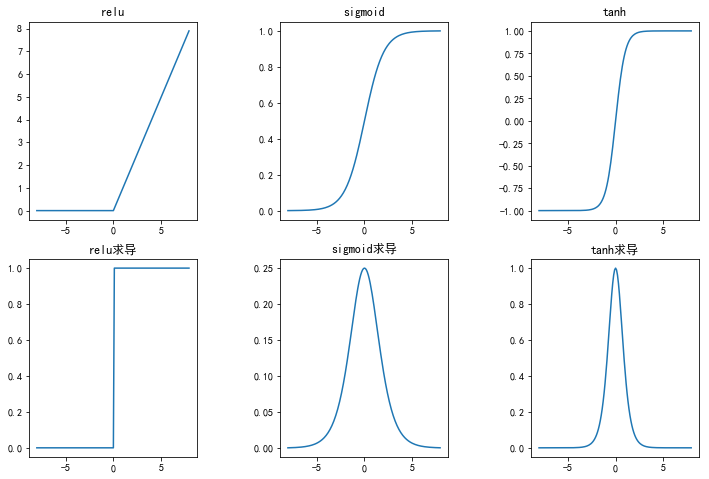

In [20]:
# 画图
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False

x = nd.arange(-8.0,8.0,0.1)
x.attach_grad()

fig = plt.figure(figsize=(12,8))
plt.subplots_adjust(wspace = 0.5, hspace = 0.2)

ax1 = fig.add_subplot(2,3,1)
ax2 = fig.add_subplot(2,3,2)
ax3 = fig.add_subplot(2,3,3)

ax4 = fig.add_subplot(2,3,4)
ax5 = fig.add_subplot(2,3,5)
ax6 = fig.add_subplot(2,3,6)

ax1.plot(x.asnumpy(),activation(x,"relu").asnumpy())
ax1.set_title("relu")

ax2.plot(x.asnumpy(),activation(x,"sigmoid").asnumpy())
ax2.set_title("sigmoid")

ax3.plot(x.asnumpy(),activation(x,"tanh").asnumpy())
ax3.set_title("tanh")

with autograd.record():
    y_relu = activation(x,"relu")
y_relu.backward()

ax4.plot(x.asnumpy(),x.grad.asnumpy())
ax4.set_title("relu求导")


with autograd.record():
    y_sigmoid = activation(x,"sigmoid")
y_sigmoid.backward()

ax5.plot(x.asnumpy(),x.grad.asnumpy())
ax5.set_title("sigmoid求导")

with autograd.record():
    y_relu = activation(x,"tanh")
y_relu.backward()

ax6.plot(x.asnumpy(),x.grad.asnumpy())
ax6.set_title("tanh求导")

#### **3、多层感知机**

多层感知机就是含有至少一个隐藏层的由全连接层组成的神经网络，且每个隐藏层的输出通过激活函数进行变换。多层感知机的层数和各隐藏层中隐藏单元个数都是超参数。

多层感知机按以下方式计算输出：

#### $H = \phi(XW_h + b_h) \\ O = HW_o + b_0$ 

其中，$\phi$ 表示激活函数。在分类问题中，对输入 $O$ 做 softmax运算，并使用 softmax 回归中的交叉熵损失函数。 在回归问题中，我们将输出层的输出个数设为1，并将输出 $O$ 直接提供给线性回归中使用的平方损失函数。



In [30]:
%matplotlib inline
import d2lzh as d2l
from mxnet import nd
from mxnet.gluon import loss as gloss 

#######################  获取和读取数据
batch_size = 256 
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

####################### 定义模型
num_inputs,num_outputs,num_hiddens = 784,10,256 # 图像大小为28*28 = 784 输出有10个类别，设隐含层单元个数为256个

# 初始化权重和偏置
# 输入层权重
w1 = nd.random.normal(scale = 0.01, shape = (num_inputs,num_hiddens))
b1 = nd.zeros(num_hiddens)

# 隐含层权重
w2 = nd.random.normal(scale = 0.01, shape = (num_hiddens,num_outputs))
b2 = nd.zeros(num_outputs)

params = [w1,b1,w2,b2]

for param in params:
    param.attach_grad()
    
####################### 定义激活函数
def relu(X):
    return nd.maximum(X,0)


####################### 定义模型
def net(X):
    X = X.reshape((-1,num_inputs))
    H = relu(nd.dot(X,w1) + b1)
    return nd.dot(H,w2) + b2

####################### 定义损失函数
loss = gloss.SoftmaxCrossEntropyLoss()

####################### 训练模型
num_epochs,lr = 5,0.5 
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, params, lr)


epoch 1, loss 0.8577, train acc 0.681, test acc 0.801
epoch 2, loss 0.5085, train acc 0.811, test acc 0.842
epoch 3, loss 0.4380, train acc 0.838, test acc 0.861
epoch 4, loss 0.4027, train acc 0.852, test acc 0.857
epoch 5, loss 0.3822, train acc 0.859, test acc 0.865


In [45]:
################################################# 多层感知机的简洁实现 

import d2lzh as d2l
from mxnet import gluon,init 
from mxnet.gluon import loss as gloss,nn 

# 定义模型 多加了一层全连接层作为隐藏层

net = nn.Sequential()
with net.name_scope():
    net.add(nn.Dense(256, activation = 'relu')) # 隐藏层
    net.add(nn.Dense(128, activation = 'relu')) # 隐藏层
    net.add(nn.Dense(10))                      # 输出层
net.initialize(init.Normal(sigma = 0.01))

# 读取并训练模型
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

loss = gloss.SoftmaxCrossEntropyLoss()
trainer = gluon.Trainer(net.collect_params(), 'sgd',{'learning_rate': 0.5})
num_epochs = 5
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, None, None, trainer)


epoch 1, loss 1.2390, train acc 0.522, test acc 0.702
epoch 2, loss 0.6794, train acc 0.746, test acc 0.800
epoch 3, loss 0.4895, train acc 0.817, test acc 0.837
epoch 4, loss 0.4411, train acc 0.835, test acc 0.859
epoch 5, loss 0.3949, train acc 0.853, test acc 0.863


<font size = 4> **权重误差**</font>

In [17]:
# 定义数据
%matplotlib inline 
import d2lzh as d2l
from mxnet import autograd,gluon,init,nd 
from mxnet.gluon import data as gdata,loss as gloss,nn

n_train,n_test, num_inputs = 20,100,200

true_w,true_b = nd.ones((num_inputs,1)) *0.01, 0.05 

features = nd.random.normal( shape = (n_train + n_test , num_inputs))
labels = nd.dot(features, true_w) + true_b 
labels += nd.random.normal(scale = 0.01, shape = labels.shape)

train_features, test_features = features[:n_train,:],features[n_train: , :]
train_labels, test_labels = labels[:n_train], labels[n_train:]



In [22]:
################################ 从0 初始

# 初始化模型参数 
def init_params():
    w = nd.random.normal(scale = 1,shape = (num_inputs, 1))
    b = nd.zeros(shape = (1,))
    w.attach_grad()
    b.attach_grad()
    return [w,b]


# 定义 L2范数惩罚项
def l2_penalty(w):
    return (w**2).sum()/2


# 定义训练和测试数据
batch_size, num_epochs,lr = 1,100,0.003
net, loss = d2l.linreg, d2l.squared_loss
train_iter = gdata.DataLoader(gdata.ArrayDataset(train_features, train_labels), batch_size, shuffle= True)

def fit_and_plot(lambd):
    w, b = init_params()
    train_ls,test_ls = [], []
    for _ in range(num_epochs):
        for X,y in train_iter:
            with autograd.record():
                # 添加 了l2范数惩罚项
                l = loss(net(X,w,b), y ) + lambd * l2_penalty(w)
            l.backward()
            d2l.sgd([w,b],lr,batch_size)
        train_ls.append(loss(net(train_features, w, b), train_labels).mean().asscalar())
        test_ls.append(loss(net(test_features,w,b), test_labels).mean().asscalar())
        
    d2l.semilogy(range(1,num_epochs + 1), train_ls, "epochs","loss",
                 range(1,num_epochs + 1) , test_ls,["train","test"])
    print("L2 normal of w: ",w.norm().asscalar())



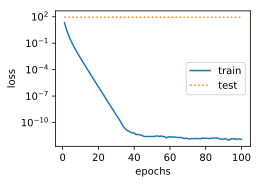

L2 normal of w:  13.93664


In [25]:
fit_and_plot(lambd=0)

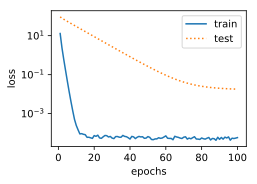

L2 normal of w:  0.060436178


In [26]:
fit_and_plot(lambd=1)

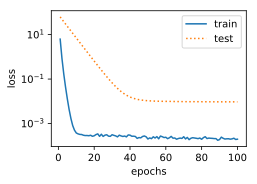

L2 normal of w:  0.043560624


In [27]:
fit_and_plot(lambd=2)

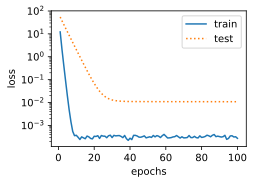

L2 normal of w:  0.03966288


In [28]:
fit_and_plot(lambd=3)

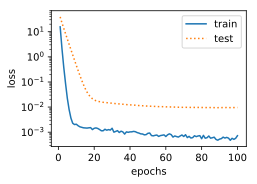

L2 normal of w:  0.036812913


In [29]:
fit_and_plot(lambd=4)

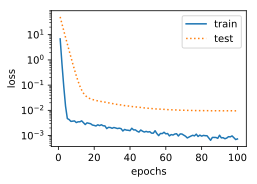

L2 normal of w:  0.03703267


In [30]:
fit_and_plot(lambd=5)

In [42]:
####################################### 简洁实现 

def fit_and_plot_gluon(wd):
    net = nn.Sequential()
    net.add(nn.Dense(1))
    net.initialize(init.Normal(sigma = 1))
    # 对权重参数衰减，权重名称一般以weight结尾
    trainer_w = gluon.Trainer(net.collect_params('.*weight'), 'sgd', {'learning_rate': lr, 'wd':wd}) # wd:权重衰减
    # 不对偏差参数衰减。 偏差名称一般是以bias结尾
    trainer_b = gluon.Trainer(net.collect_params('.*bias'), 'sgd', {'learning_rate': lr})
    
    train_ls , test_ls = [],[]
    for _ in range(num_epochs):
        for X,y in train_iter:
            with autograd.record():
                l = loss(net(X),y)
            l.backward()
            # 对两个 Trainer实例分别调用 step函数，从而分别更新权重和偏差
            trainer_w.step(batch_size)
            trainer_b.step(batch_size)
            
        train_ls.append(loss(net(train_features), train_labels).mean().asscalar())
        test_ls.append(loss(net(test_features), test_labels).mean().asscalar())
        
        
    d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
                 range(1, num_epochs + 1), test_ls, ["train","test"])

    print("L2 norm of w:", net[0].weight.data().norm().asscalar())
        

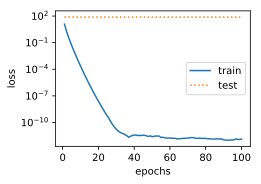

L2 norm of w: 13.268964


In [43]:
fit_and_plot_gluon(0)

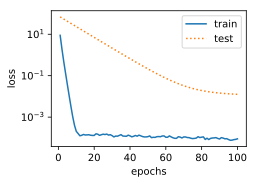

L2 norm of w: 0.064282745


In [44]:
fit_and_plot_gluon(1)

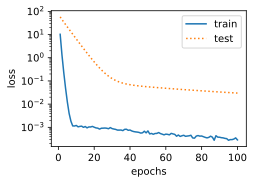

L2 norm of w: 0.058776952


In [45]:
fit_and_plot_gluon(2)

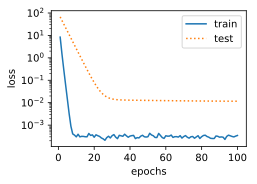

L2 norm of w: 0.038886826


In [46]:
fit_and_plot_gluon(3)

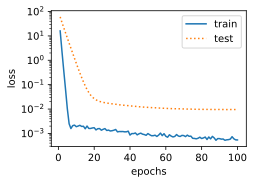

L2 norm of w: 0.039015528


In [47]:
fit_and_plot_gluon(4)

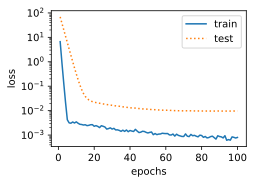

L2 norm of w: 0.03616847


In [48]:
fit_and_plot_gluon(5)

<font size=4>**丢弃法**</font>

In [58]:
########################### 从零开始
import d2lzh as d2l
from mxnet import autograd,gluon,init,nd 
from mxnet.gluon import loss as gloss,nn

def dropout(X,drop_prob):
    assert 0<=drop_prob<=1
    keep_prob = 1 - drop_prob
    if keep_prob == 0: # 把全部元素丢弃
        return X.zeros_like()
    mask = nd.random.uniform(0,1,X.shape) < keep_prob
    
    return mask * X/keep_prob
    

In [59]:
X = nd.arange(16).reshape((2,8))
dropout(X,0)


[[ 0.  1.  2.  3.  4.  5.  6.  7.]
 [ 8.  9. 10. 11. 12. 13. 14. 15.]]
<NDArray 2x8 @cpu(0)>

In [62]:
dropout(X,0.5)


[[ 0.  0.  0.  6.  8.  0. 12. 14.]
 [16.  0. 20. 22.  0.  0. 28.  0.]]
<NDArray 2x8 @cpu(0)>

In [72]:
# 定义模型参数
num_inputs, num_outputs, num_hidden1, num_hidden2 = 784, 10, 256, 256

w1 = nd.random.normal(scale = 0.01, shape = (num_inputs, num_hidden1))
b1 = nd.zeros(num_hidden1)

w2 = nd.random.normal(scale = 0.01, shape = (num_hidden1, num_hidden2))
b2 = nd.zeros(num_hidden2)

w3 = nd.random.normal(scale = 0.01, shape = (num_hidden2, num_outputs))
b3 = nd.zeros(num_outputs)

params = [w1,b1,w2,b2,w3,b3]
for param in params:
    param.attach_grad()
    
# 定义模型
drop_prob1, drop_prob2 = 0.2, 0.5

def net(X):
    X = X.reshape((-1, num_inputs))
    H1 = (nd.dot(X,w1) + b1).relu()
    if autograd.is_training(): # 只要训练模型时使用丢弃法
        H1 = dropout(H1, drop_prob1) # 在第一层全连接后添加丢弃层
        
    H2 = (nd.dot(H1,w2) + b2).relu()
    if autograd.is_training():
        H2 = dropout(H2, drop_prob2) # 在第二层全连接后添加丢弃层
        
    return nd.dot(H2,w3) + b3


# 训练和测试模型
num_epochs, lr, batch_size = 5,0.5, 256
loss = gloss.SoftmaxCrossEntropyLoss()
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, params, lr)

epoch 1, loss 1.1435, train acc 0.550, test acc 0.771
epoch 2, loss 0.5815, train acc 0.783, test acc 0.832
epoch 3, loss 0.4832, train acc 0.825, test acc 0.847
epoch 4, loss 0.4464, train acc 0.839, test acc 0.864
epoch 5, loss 0.4138, train acc 0.848, test acc 0.867


In [74]:
########################## 简洁实现
net = nn.Sequential()

net.add(nn.Dense(256, activation="relu"), 
        nn.Dropout(drop_prob1),  # 在第一个全连接层后添加丢弃层
        nn.Dense(256, activation = "relu"),
        nn.Dropout(drop_prob2),  # 在第二个全连接层后添加丢弃层
        nn.Dense(10))
net.initialize(init.Normal(sigma = 0.01))

# 训练并测试模型
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': lr})
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, None, None, trainer)

epoch 1, loss 1.2360, train acc 0.534, test acc 0.786
epoch 2, loss 0.5912, train acc 0.780, test acc 0.835
epoch 3, loss 0.5063, train acc 0.815, test acc 0.846
epoch 4, loss 0.4591, train acc 0.833, test acc 0.854
epoch 5, loss 0.4289, train acc 0.844, test acc 0.862
